# The ZnFlow Package

Define Node connections using a directional multigraph.
Nodes are connected through Node attributes.
A Node can have multiple connections to another Node through different Attributes.
Each Node is definied by a unique `_id_` which could be automatically generated based on the state of the Node.

In [1]:
import znflow
import dataclasses

A Node is inherited from `znflow.Node` and can have many different `znflow.EdgeAttribute` that will connect the Nodes to  other Nodes or behave as inputs / outputs from the Node.
In general a `Node` is very similar to a dataclass and even implements a `_post_init_` method.
We equip our `Node` with a `run` method that computes the `outputs` based on the `inputs`.

In [2]:
@dataclasses.dataclass
class Node(znflow.Node):
    inputs: float
    outputs: float = None
    
    def run(self):
        self.outputs = self.inputs * 2

In [3]:
node1 = Node(inputs=25)
node1.run()
node1

Node(inputs=25, outputs=50)

We can now create multiple Nodes and connect them. Nodes are connected through `znflow.GraphManager` as follows.
Every Node inside the contextmanager will automatically be stored inside the `dag` object.

In [4]:
with znflow.DiGraph() as graph:
    node1 = Node(inputs=25)
    node2 = Node(inputs=node1.outputs) # TODO Node(inputs=node1)

If we look at the new Node, we see that `Node.inputs` is now a `NodeConnector` to the connected Node.

In [5]:
node1

Node(inputs=25, outputs=None)

In [6]:
node2

Node(inputs=Connection(instance=Node(inputs=25, outputs=None), attribute='outputs'), outputs=None)

Using `networkx` we can visualize the connection.

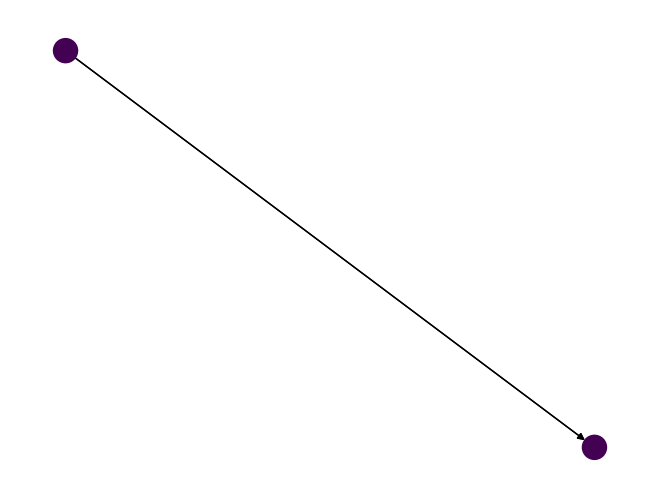

In [7]:
znflow.draw(graph)

Another way of connecting Nodes is through `znflow.DiGraph().write_graph`.
It is important to mention, that we can not use `node1.outputs` here, because we know `node1.outputs is None`. Therefore, we have to replace it by `node1 @ "outputs"`

In [8]:
node1 = Node(inputs=25)
node2 = Node(inputs=node1 @ "outputs")
print(f"{node1.outputs = }")
print(f'{node1 @ "outputs" = }')
print(f"{node2 = }")

node1.outputs = None
node1 @ "outputs" = Connection(instance=Node(inputs=25, outputs=None), attribute='outputs')
node2 = Node(inputs=Connection(instance=Node(inputs=25, outputs=None), attribute='outputs'), outputs=None)


In [9]:
graph = znflow.DiGraph()
graph.write_graph(node1, node2)

In [10]:
graph.nodes

NodeView((UUID('9e958c3b-2cd8-437a-8c91-e8a0eb6d072b'), UUID('1a9a0646-b641-41ba-8234-e5bce8e54911')))

In [11]:
[graph.edges[x] for x in graph.edges]

[{'u_attr': 'outputs', 'v_attr': 'inputs'}]

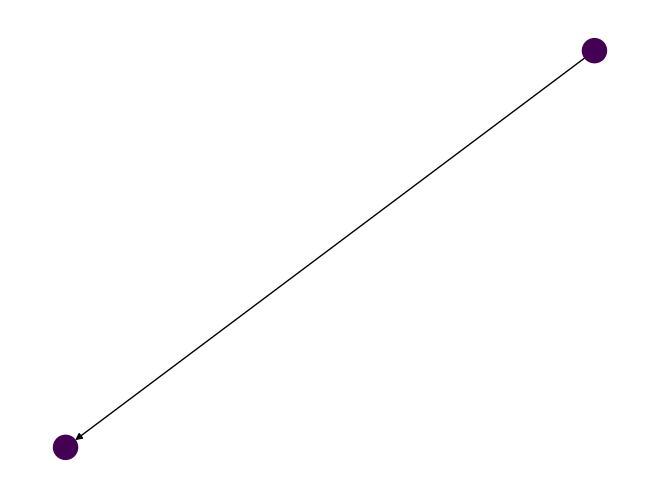

In [12]:
znflow.draw(graph)

# Run the Graph

First let's build some more interesting graphs:

In [13]:
@dataclasses.dataclass
class SumNodes(znflow.Node):
    inputs: float
    outputs: float = None

    def run(self):
        self.outputs = sum(self.inputs)

In [14]:
with znflow.DiGraph() as graph:
    node1 = Node(inputs=5)
    node2 = Node(inputs=10)
    node3 = Node(inputs=node1.outputs)
    node4 = Node(inputs=node2.outputs)
    node5 = SumNodes(inputs=[node3.outputs, node4.outputs])
    node6 = SumNodes(inputs=[node2.outputs, node5.outputs])
    node7 = SumNodes(inputs=[node6.outputs])

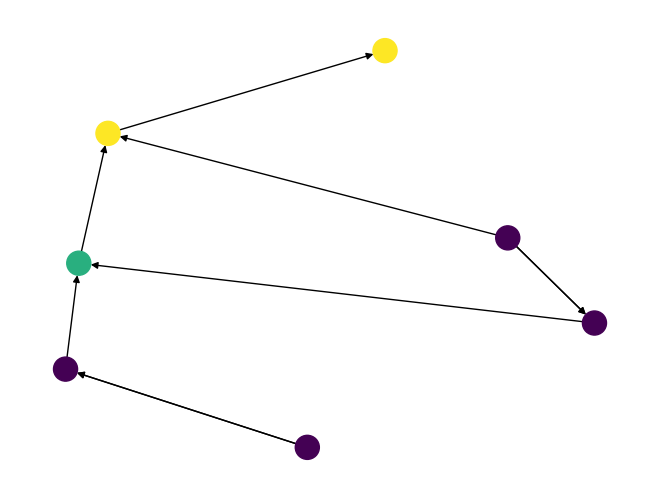

In [15]:
znflow.draw(graph)

In [16]:
graph.run() # default is to call node.run()
graph.nodes

NodeView((UUID('5b0d5286-7150-4d80-af09-1e454c85cfee'), UUID('89fca2e1-1127-4029-ba1f-1a183d55a715'), UUID('12ed54f8-0d06-437c-8af0-3b03269f043a'), UUID('b716dd9a-465e-45e8-acff-8abbf572f82c'), UUID('e2c9bfab-33c5-419b-9201-82378a3f7a29'), UUID('181c1c59-0a63-4a7e-a71b-7c7344d53478'), UUID('7f1b944d-7bd2-4f70-a606-5d47afbefb64')))

Or even more nested

In [17]:
import random
k = 3
j = 3
i = 3

with znflow.DiGraph() as graph:
    kdx_nodes = []
    for kdx in range(k):
        jdx_nodes = []
        for jdx in range(j):
            idx_nodes = []
            for idx in range(i):
                idx_nodes.append(Node(inputs=random.random()))
            jdx_nodes.append(SumNodes(inputs=[x.outputs for x in idx_nodes]))
        kdx_nodes.append(SumNodes(inputs=[x.outputs for x in jdx_nodes]))
            
    end_node = SumNodes(inputs=[x.outputs for x in kdx_nodes])

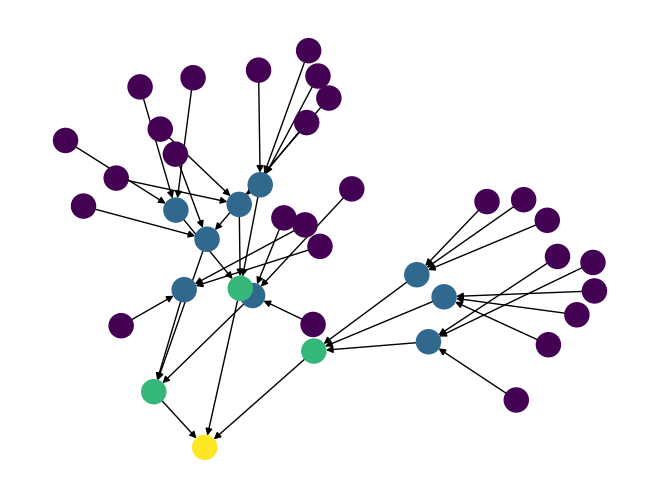

In [18]:
# nx.draw(dag)
znflow.draw(graph)

In [19]:
%time graph.run() # default is to call node.run()
# # [x._id_ for x in dag.nodes]
[graph.nodes[x]["value"] for x in graph.nodes]

CPU times: total: 188 ms
Wall time: 543 ms


[Node(inputs=0.10663079059035918, outputs=0.21326158118071836),
 Node(inputs=0.30852669713678826, outputs=0.6170533942735765),
 Node(inputs=0.42205628383069327, outputs=0.8441125676613865),
 SumNodes(inputs=[0.21326158118071836, 0.6170533942735765, 0.8441125676613865], outputs=1.6744275431156814),
 Node(inputs=0.6510224933866161, outputs=1.3020449867732322),
 Node(inputs=0.1295009840471666, outputs=0.2590019680943332),
 Node(inputs=0.3126692143734394, outputs=0.6253384287468788),
 SumNodes(inputs=[1.3020449867732322, 0.2590019680943332, 0.6253384287468788], outputs=2.1863853836144442),
 Node(inputs=0.47455176145635425, outputs=0.9491035229127085),
 Node(inputs=0.0828630775610798, outputs=0.1657261551221596),
 Node(inputs=0.8899480785337845, outputs=1.779896157067569),
 SumNodes(inputs=[0.9491035229127085, 0.1657261551221596, 1.779896157067569], outputs=2.894725835102437),
 SumNodes(inputs=[1.6744275431156814, 2.1863853836144442, 2.894725835102437], outputs=6.755538761832563),
 Node(inp

In [20]:
end_node

SumNodes(inputs=[6.755538761832563, 9.562851511294202, 10.71372393128323], outputs=27.032114204409996)